In [3]:
# Importations et réglage de la reproductibilité
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess # replaced by vgg16 preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gradio as gr

# Pour la reproductibilité
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
!pip install gradio

In [ ]:
# Définition des groupes d'âge (si vous souhaitez les utiliser pour une autre tâche)
age_groups = [
    (0, 9), (10, 19), (20, 29), (30, 39), (40, 49),
    (50, 59), (60, 69), (70, 79), (80, 89), (90, 99), (100, 120)
]
num_age_groups = len(age_groups)

def age_to_group(age, age_groups=age_groups):
    """Convertit un âge en indice de groupe."""
    for idx, (low, high) in enumerate(age_groups):
        if low <= age <= high:
            return idx
    return num_age_groups - 1

In [4]:
# Fonctions d'extraction et de chargement du dataset UTKFace
def extract_age_gender(filename):
    """Extrait l'âge et le genre du nom de fichier UTKFace."""
    parts = filename.split("_")
    age = int(parts[0])
    gender = int(parts[1])
    return age, gender

def load_dataset(image_folder):
    """Charge les chemins d'image et labels depuis le dossier UTKFace."""
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    ages, genders = zip(*[extract_age_gender(f) for f in image_files])
    return image_paths, list(ages), list(genders)

# Définir le chemin vers le dataset
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
image_paths, ages, genders = load_dataset(DATA_DIR)

# Mélanger les données
image_paths, ages, genders = shuffle(image_paths, ages, genders, random_state=42)

# Séparation en ensembles train et validation (80% / 20%)
train_paths, val_paths, train_ages, val_ages, train_genders, val_genders = train_test_split(
    image_paths, ages, genders, test_size=0.2, random_state=42
)

print("Nombre d'images d'entraînement :", len(train_paths))
print("Nombre d'images de validation   :", len(val_paths))

Nombre d'images d'entraînement : 18966
Nombre d'images de validation   : 4742


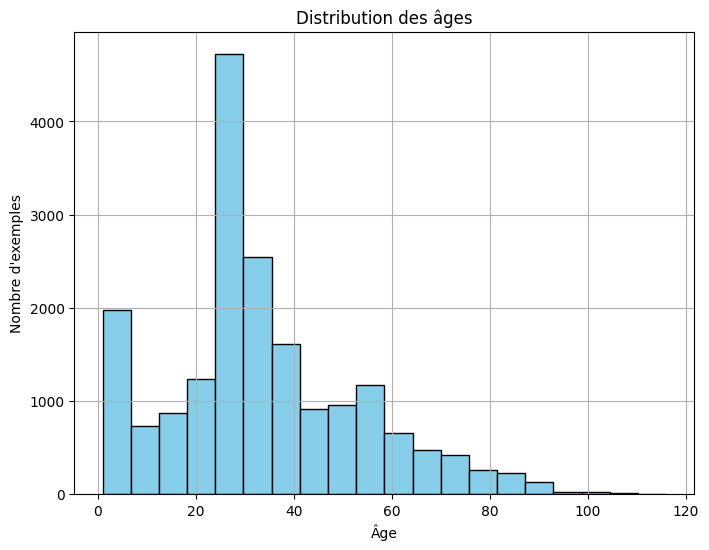

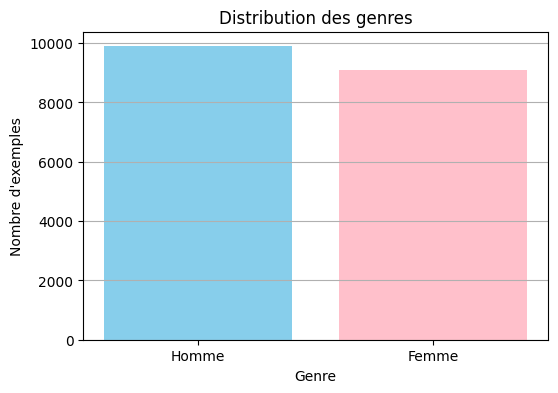

In [5]:
# Visualisation des distributions (utile pour comprendre le dataset)
def plot_age_distribution(ages):
    plt.figure(figsize=(8, 6))
    plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution des âges")
    plt.xlabel("Âge")
    plt.ylabel("Nombre d'exemples")
    plt.grid(True)
    plt.show()

def plot_gender_distribution(genders):
    gender_labels = ["Homme", "Femme"]
    counts = [genders.count(0), genders.count(1)]
    plt.figure(figsize=(6, 4))
    plt.bar(gender_labels, counts, color=['skyblue', 'pink'])
    plt.title("Distribution des genres")
    plt.xlabel("Genre")
    plt.ylabel("Nombre d'exemples")
    plt.grid(axis='y')
    plt.show()

plot_age_distribution(train_ages)
plot_gender_distribution(train_genders)

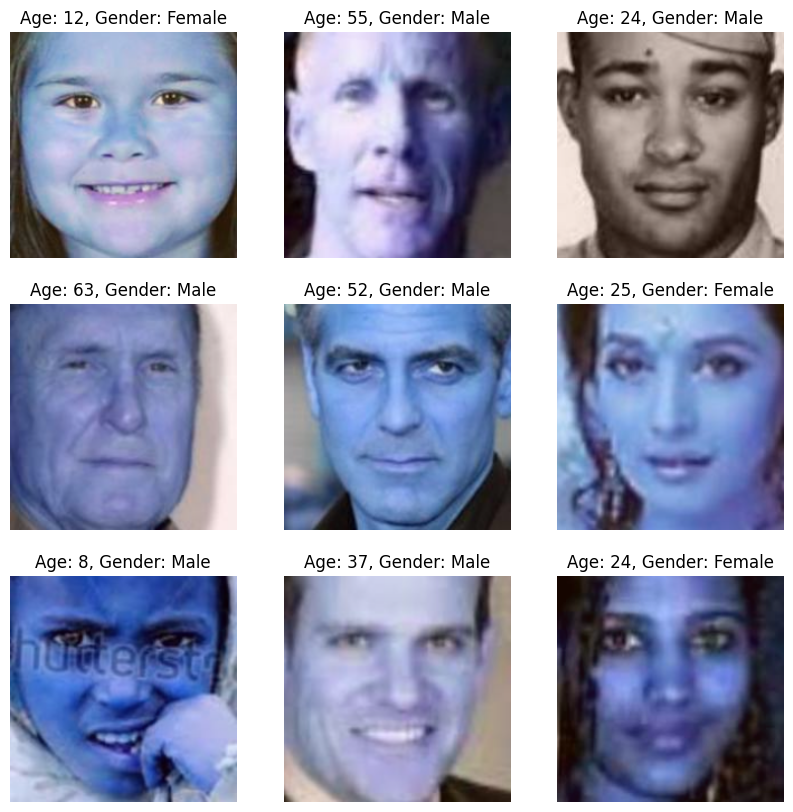

In [6]:
# --- Fonctions de prétraitement ---
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

def process_path_train(path, age, gender, image_size=IMAGE_SIZE):
    """Prétraitement pour l'entraînement avec data augmentation et VGG16 preprocessing."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = vgg16_preprocess(image) # Use VGG16 preprocessing
    normalized_age = tf.cast(age, tf.float32) / 116.0 # Normalize age to [0, 1]
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

def process_path_val(path, age, gender, image_size=IMAGE_SIZE):
    """Prétraitement pour la validation avec VGG16 preprocessing (sans augmentation)."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = vgg16_preprocess(image) # Use VGG16 preprocessing
    normalized_age = tf.cast(age, tf.float32) / 116.0 # Normalize age to [0, 1]
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

# --- Création des datasets ---
def create_dataset(paths, ages, genders, process_func, batch_size=BATCH_SIZE, shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices((paths, ages, genders))
    ds = ds.map(lambda p, a, g: process_func(p, a, g, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(shuffle_buffer) # Shuffle only for training dataset
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_paths, train_ages, train_genders, process_path_train)
val_ds = create_dataset(val_paths, val_ages, val_genders, process_path_val, shuffle_buffer=1) # No need to shuffle validation

# --- Visualisation d'un batch pour vérifier le prétraitement ---
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display 9 images from the batch
        plt.subplot(3, 3, i + 1)
        image = tf.keras.preprocessing.image.array_to_img(images[i]) # Convert back to PIL image for display if needed
        plt.imshow(image)
        age = labels['age_output'][i].numpy() * 116
        gender = "Female" if labels['gender_output'][i].numpy() >= 0.5 else "Male"
        plt.title(f"Age: {age:.0f}, Gender: {gender}")
        plt.axis('off')
    plt.show()

In [7]:
from tensorflow.keras.applications import VGG16 # Import VGG16
# from tensorflow.keras.applications import EfficientNetB1 # Removed EfficientNet import
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

IMAGE_SIZE = (224, 224)

# --- Hyperparamètres Ajustés pour Augmenter la Capacité et la Régularisation ---
L2_FACTOR = 0.0005     
DROPOUT_RATE = 0.5      
LEARNING_RATE = 1e-4   
DENSE_UNITS_LAYER1 = 1024 
DENSE_UNITS_LAYER2 = 512  

# Définition de l'entrée
input_tensor = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Charger VGG16 sans les couches de classification
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)) # Use VGG16
base_model_vgg16.trainable = False # On garde la base gelée pour l'instant

# --- Tête de classification personnalisée (couches denses AUGMENTÉES et Dropout Ajusté) ---
x = base_model_vgg16(input_tensor) # Use VGG16 base model
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

# Couches denses - TAILLES GRANDES et DROPOUT AJUSTÉ
x = layers.Dense(DENSE_UNITS_LAYER1, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x) # **1ère couche dense (1024 unités)**
x = layers.Dropout(DROPOUT_RATE)(x) # **Dropout à 0.5 (inchangé)** - Régularisation forte
x = layers.Dense(DENSE_UNITS_LAYER2, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x) # **2e couche dense (512 unités)**
x = layers.Dropout(DROPOUT_RATE)(x) # **Dropout REVIENT à 0.5 pour la 2e couche** - Régularisation plus forte aussi ici

# Couches de sortie (inchangées)
age_output = layers.Dense(1, activation='linear', name='age_output')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

# Créer le modèle VGG16
model_vgg16 = Model(inputs=input_tensor, outputs=[age_output, gender_output]) # Model name changed to vgg16

# Afficher le résumé du modèle
model_vgg16.summary() # Use vgg16 model

# Compilation du modèle (inchangée)
model_vgg16.compile(optimizer=Adam(learning_rate=LEARNING_RATE), # Use vgg16 model
                     loss={'age_output': 'mae', 'gender_output': 'binary_crossentropy'},
                     metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512)            │          2,048 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024)           │        525,312 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │        524,800 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 512)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            513 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            513 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,767,874 (60.15 MB)

 Trainable params: 1,052,162 (4.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [8]:
# Entraînement du modèle avec callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='/kaggle/working/checkpoints/b_vgg16_age_gender.keras', # checkpoint path updated to vgg16
                    monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

history_vgg16 = model_vgg16.fit( # Use vgg16 model
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - age_output_loss: 0.6471 - age_output_mae: 0.6471 - gender_output_accuracy: 0.6849 - gender_output_loss: 0.6047 - loss: 1.9304
Epoch 1: val_loss improved from inf to 1.21444, saving model to /kaggle/working/checkpoints/b_vgg16_age_gender.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 213ms/step - age_output_loss: 0.6468 - age_output_mae: 0.6468 - gender_output_accuracy: 0.6850 - gender_output_loss: 0.6045 - loss: 1.9299 - val_age_output_loss: 0.1517 - val_age_output_mae: 0.1513 - val_gender_output_accuracy: 0.8317 - val_gender_output_loss: 0.3963 - val_loss: 1.2144
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - age_output_loss: 0.2526 - age_output_mae: 0.2526 - gender_output_accuracy: 0.8146 - gender_output_loss: 0.4150 - loss: 1.3301
Epoch 2: val_loss improved from 1.21444 to 1.15211, saving model to /kaggle/working/checkpoints/b_vgg16_age_gender.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 108s 179ms/step - age_output_loss: 0.2526 - age_

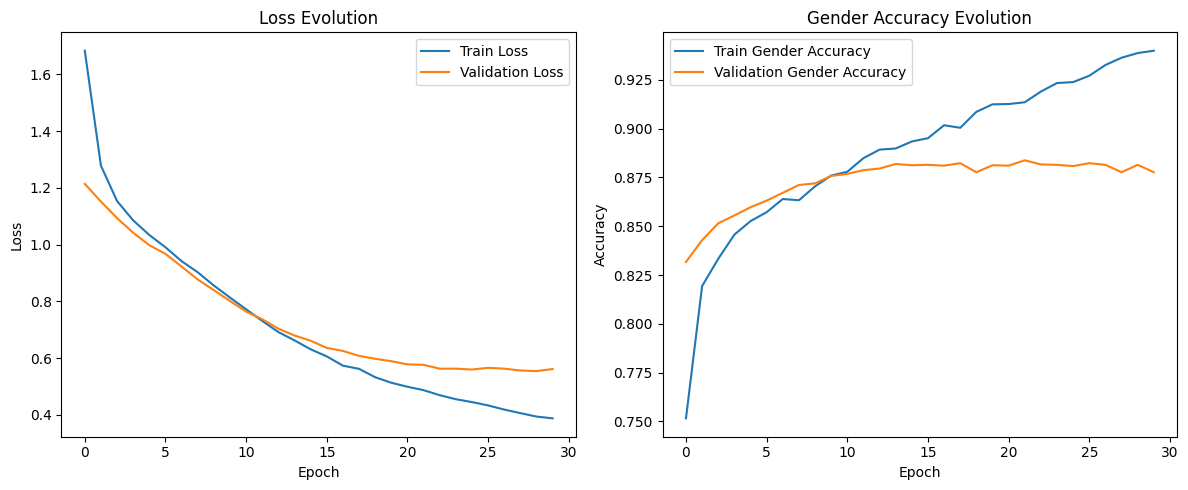

In [9]:
# Visualisation des courbes d'apprentissage
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['gender_output_accuracy'], label='Train Gender Accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Validation Gender Accuracy')
    plt.title('Gender Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_vgg16) # Use vgg16 history

In [10]:
def age_accuracy(y_true, y_pred, tol=5.0):
    """
    Calcule l'accuracy pour la prédiction de l'âge.
    On considère qu'une prédiction est correcte si l'erreur absolue
    (en années) est inférieure ou égale à tol (par défaut 5 ans).

    Les valeurs y_true et y_pred sont supposées être normalisées (ex : divisées par 120).
    """
    # Dénormalisation (si l'âge maximum est 120)
    y_true_denorm = y_true * 116.0
    y_pred_denorm = y_pred * 116.0
    # Calcul de la différence absolue
    diff = tf.abs(y_true_denorm - y_pred_denorm)
    # On considère la prédiction correcte si diff <= tol
    correct = tf.cast(tf.less_equal(diff, tol), tf.float32)
    # Retourne la proportion de prédictions correctes
    return tf.reduce_mean(correct)

print("age_accuracy function defined (check if this line prints after running)")

age_accuracy function defined (check if this line prints after running)


In [ ]:
 [code] {"execution":{"iopub.status.busy":"2025-03-05T20:41:54.322684Z","iopub.execute_input":"2025-03-05T20:41:54.322958Z","iopub.status.idle":"2025-03-05T20:42:09.415623Z","shell.execute_reply.started":"2025-03-05T20:41:54.322934Z","shell.execute_reply":"2025-03-05T20:42:09.414794Z"}}


--- Évaluation de la Prédiction de l'Âge ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1

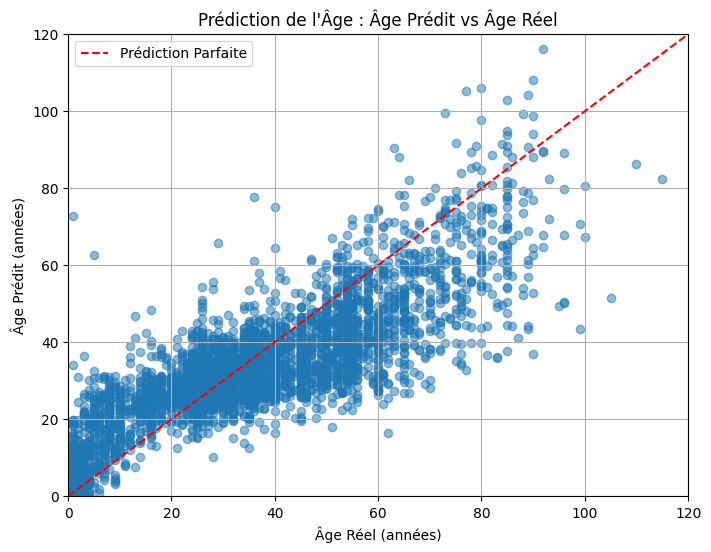

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_age_performance(model, val_ds):
    """
    Évalue la performance de la prédiction de l'âge et affiche les métriques.
    """
    true_ages = []
    predicted_ages_normalized = []

    for images, labels in val_ds:
        true_ages.extend(labels['age_output'].numpy())
        predicted_ages_batch_normalized = model.predict(images)[0] # Index 0 pour l'âge
        predicted_ages_normalized.extend(predicted_ages_batch_normalized.flatten())

    true_ages = np.array(true_ages) * 116.0  # Dénormaliser les âges réels
    predicted_ages = np.array(predicted_ages_normalized) * 116.0 # Dénormaliser les âges prédits

    # Calcul des métriques de régression
    mae = mean_absolute_error(true_ages, predicted_ages)
    mse = mean_squared_error(true_ages, predicted_ages)
    rmse = np.sqrt(mse)

    print("\nMétriques de Régression pour l'Âge :")
    print(f"  Mean Absolute Error (MAE): {mae:.2f} years")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Graphique de dispersion (Scatter plot) : Prédit vs Réel
    plt.figure(figsize=(8, 6))
    plt.scatter(true_ages, predicted_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite') # Ligne de référence pour prédiction parfaite
    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title("Prédiction de l'Âge : Âge Prédit vs Âge Réel")
    plt.xlim([0, 120]) # Limiter l'échelle pour la plage d'âge typique
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.show()


# Appel de la fonction d'évaluation de l'âge après l'évaluation du genre
print("\n--- Évaluation de la Prédiction de l'Âge ---")
evaluate_age_performance(model_vgg16, val_ds) # Use vgg16 model

149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - age_output_loss: 0.0695 - age_output_mae: 0.0695 - gender_output_accuracy: 0.8834 - gender_output_loss: 0.2955 - loss: 0.5309
Validation Loss (Total): 0.5546391606330872
Validation Age MAE: 0.06911742687225342
Validation Gender Accuracy: 0.8814846277236938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━

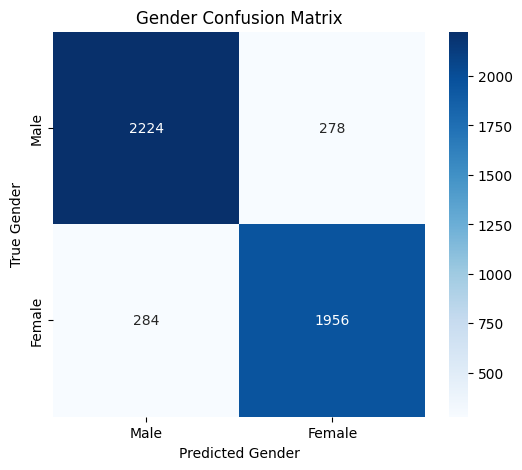

In [12]:
# Évaluation détaillée sur l'ensemble de validation
def evaluate_gender_performance(model, val_ds):
    """Evaluates gender classification and prints metrics."""
    true_genders = []
    predicted_genders_probs = []
    for images, labels in val_ds:
        true_genders.extend(labels['gender_output'].numpy())
        predicted_gender_probs_batch = model.predict(images)[1] # Index 1 for gender
        predicted_genders_probs.extend(predicted_gender_probs_batch.flatten())

    predicted_genders = np.round(predicted_genders_probs)
    true_genders = np.array(true_genders)
    predicted_genders = np.array(predicted_genders)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_genders, predicted_genders)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_genders, predicted_genders))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.title('Gender Confusion Matrix')
    plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

results_val = model_vgg16.evaluate(val_ds) # Use vgg16 model
print("Validation Loss (Total):", results_val[0])
print("Validation Age MAE:", results_val[1])
print("Validation Gender Accuracy:", results_val[4]) # Index 4 for gender accuracy

evaluate_gender_performance(model_vgg16, val_ds) # Use vgg16 model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


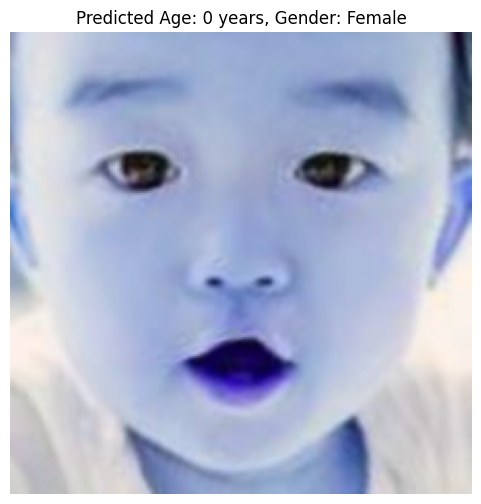

Image Path: /kaggle/input/utkface-new/UTKFace/2_0_2_20161219212035798.jpg.chip.jpg
Predicted Age: 0 years, Predicted Gender: Female


In [17]:
# Fonction d'inférence pour une image à partir du chemin
def inference_age_gender_from_path_v2(model, image_path, image_size=IMAGE_SIZE, plot=False):
    """Inférence âge et genre à partir d'un chemin d'image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = vgg16_preprocess(image) # Use VGG16 preprocessing
    input_tensor = tf.expand_dims(image, axis=0) # Add batch dimension
    predictions = model.predict(input_tensor)
    predicted_age_normalized = predictions[0][0][0] # Age output is the first output
    predicted_age = predicted_age_normalized * 120 # Denormalize age
    predicted_gender_prob = predictions[1][0][0] # Gender output is the second output
    predicted_gender = "Female" if predicted_gender_prob >= 0.5 else "Male"

    if plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image)) # Convert back to PIL for display
        plt.title(f"Predicted Age: {predicted_age:.0f} years, Gender: {predicted_gender}")
        plt.axis('off')
        plt.show()
    return predicted_age, predicted_gender

# Exemple d'inférence
sample_image_path = val_paths[np.random.randint(0, len(val_paths))] # Get random val image path
predicted_age, predicted_gender = inference_age_gender_from_path_v2(
    model_vgg16, sample_image_path, plot=True # Use vgg16 model
)
print(f"Image Path: {sample_image_path}")
print(f"Predicted Age: {predicted_age:.0f} years, Predicted Gender: {predicted_gender}")

In [ ]:
# Gradio Interface
def gradio_inference(img):
    """Gradio wrapper function for interactive inference."""
    img_array = np.array(img)
    img_resized = tf.image.resize(img_array, IMAGE_SIZE)
    img_preprocessed = vgg16_preprocess(img_resized) # Use VGG16 preprocessing
    input_tensor = tf.expand_dims(img_preprocessed, axis=0)
    predictions = model_vgg16.predict(input_tensor) # Use vgg16 model
    pred_age = predictions[0][0][0] * 120
    pred_gender_prob = predictions[1][0][0]
    gender_label = "Female" if pred_gender_prob >= 0.5 else "Male"
    return f"Predicted Age: {pred_age:.0f} years, Predicted Gender: {gender_label}"

iface = gr.Interface(
    fn=gradio_inference,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Age and Gender Prediction with VGG16", # Updated title to VGG16
    description="Upload a face image to predict age and gender."
)
iface.launch(share=True)

149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - age_output_loss: 0.0695 - age_output_mae: 0.0695 - gender_output_accuracy: 0.8834 - gender_output_loss: 0.2955 - loss: 0.5309
Validation Loss (Total): 0.5546391606330872
Validation Age MAE: 0.06911742687225342
Validation Gender Accuracy: 0.8814846277236938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━

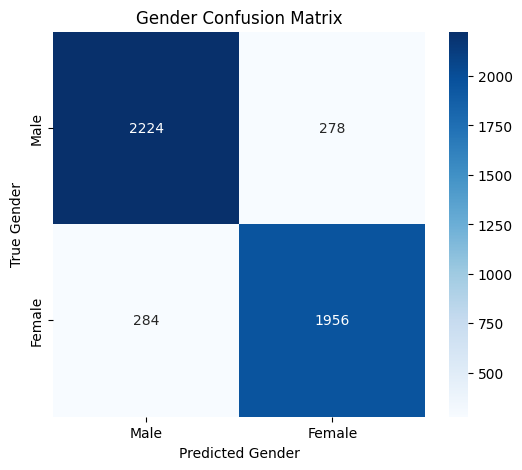

In [14]:
def evaluate_gender_performance(model, val_ds):
    """Evaluates gender classification and prints metrics."""
    true_genders = []
    predicted_genders_probs = []
    for images, labels in val_ds:
        true_genders.extend(labels['gender_output'].numpy())
        predicted_gender_probs_batch = model.predict(images)[1] # Index 1 for gender
        predicted_genders_probs.extend(predicted_gender_probs_batch.flatten())

    predicted_genders = np.round(predicted_genders_probs)
    true_genders = np.array(true_genders)
    predicted_genders = np.array(predicted_genders)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_genders, predicted_genders)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_genders, predicted_genders))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.title('Gender Confusion Matrix')
    plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

results_val = model_vgg16.evaluate(val_ds) # Use vgg16 model
print("Validation Loss (Total):", results_val[0])
print("Validation Age MAE:", results_val[1])
print("Validation Gender Accuracy:", results_val[4]) # Index 4 for gender accuracy

evaluate_gender_performance(model_vgg16, val_ds) # Use vgg16 model

In [ ]:
 [code] {"execution":{"iopub.status.busy":"2025-03-05T20:43:12.405735Z","iopub.execute_input":"2025-03-05T20:43:12.406038Z","iopub.status.idle":"2025-03-05T20:43:12.662249Z","shell.execute_reply.started":"2025-03-05T20:43:12.406013Z","shell.execute_reply":"2025-03-05T20:43:12.661539Z"}}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


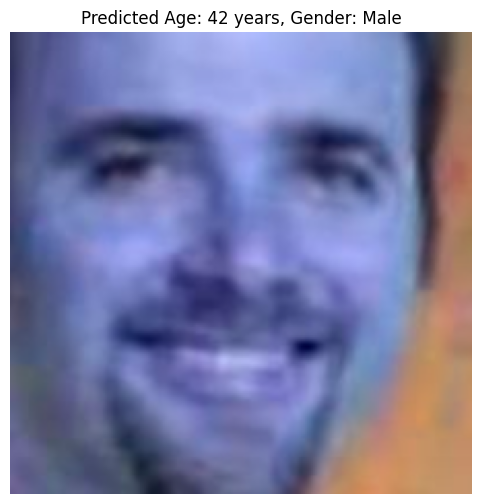

Image Path: /kaggle/input/utkface-new/UTKFace/34_0_0_20170104170059137.jpg.chip.jpg
Predicted Age: 42 years, Predicted Gender: Male


In [15]:
# Fonction d'inférence pour une image à partir du chemin
def inference_age_gender_from_path_v2(model, image_path, image_size=IMAGE_SIZE, plot=False):
    """Inférence âge et genre à partir d'un chemin d'image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = vgg16_preprocess(image) # Use VGG16 preprocessing
    input_tensor = tf.expand_dims(image, axis=0) # Add batch dimension
    predictions = model.predict(input_tensor)
    predicted_age_normalized = predictions[0][0][0] # Age output is the first output
    predicted_age = predicted_age_normalized * 116 # Denormalize age
    predicted_gender_prob = predictions[1][0][0] # Gender output is the second output
    predicted_gender = "Female" if predicted_gender_prob >= 0.5 else "Male"

    if plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image)) # Convert back to PIL for display
        plt.title(f"Predicted Age: {predicted_age:.0f} years, Gender: {predicted_gender}")
        plt.axis('off')
        plt.show()
    return predicted_age, predicted_gender

# Exemple d'inférence
sample_image_path = val_paths[np.random.randint(0, len(val_paths))] # Get random val image path
predicted_age, predicted_gender = inference_age_gender_from_path_v2(
    model_vgg16, sample_image_path, plot=True # Use vgg16 model
)
print(f"Image Path: {sample_image_path}")
print(f"Predicted Age: {predicted_age:.0f} years, Predicted Gender: {predicted_gender}")

In [ ]:
 [code]

In [ ]:
# Gradio Interface
def gradio_inference(img):
    """Gradio wrapper function for interactive inference."""
    img_array = np.array(img)
    img_resized = tf.image.resize(img_array, IMAGE_SIZE)
    img_preprocessed = vgg16_preprocess(img_resized) # Use VGG16 preprocessing
    input_tensor = tf.expand_dims(img_preprocessed, axis=0)
    predictions = model_vgg16.predict(input_tensor) # Use vgg16 model
    pred_age = predictions[0][0][0] * 116
    pred_gender_prob = predictions[1][0][0]
    gender_label = "Female" if pred_gender_prob >= 0.5 else "Male"
    return f"Predicted Age: {pred_age:.0f} years, Predicted Gender: {gender_label}"

iface = gr.Interface(
    fn=gradio_inference,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Age and Gender Prediction with VGG16", # Updated title to VGG16
    description="Upload a face image to predict age and gender."
)
iface.launch(share=True)

In [ ]:
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def evaluate_age_performance(model, val_dataset, stage="Validation"):
    """
    Évalue la performance de la prédiction de l'âge :
      - Calcul des métriques de régression (MAE, MSE, RMSE, accuracy within 5 & 10 ans)
      - Conversion des âges continus en classes d'âge et calcul de la confusion matrix.
    """
    true_ages = []
    pred_ages_norm = []

    # Collecte des prédictions
    for images, labels in val_dataset:
        true_ages.extend(labels['age_output'].numpy())
        preds = model.predict(images, verbose=0)[0]  # Prédictions de l'âge
        pred_ages_norm.extend(preds.flatten())

    true_ages = np.array(true_ages) * 116.0
    pred_ages = np.array(pred_ages_norm) * 116.0

    # Métriques de régression
    mae = mean_absolute_error(true_ages, pred_ages)
    mse = mean_squared_error(true_ages, pred_ages)
    rmse = np.sqrt(mse)

    acc_10 = np.mean(np.abs(true_ages - pred_ages) <= 10.0)  # Accuracy à ±10 ans

    print(f"\nMétriques de Régression pour l'Âge ({stage}):")
    print(f"  MAE : {mae:.2f} ans")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  Accuracy within 10 ans: {acc_10*100:.2f}%")

    # Définition des tranches d'âge
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
    age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]

    # Classification des âges en tranches
    true_bin_indices = np.digitize(true_ages, age_bins) - 1
    pred_bin_indices = np.digitize(pred_ages, age_bins) - 1

    # Correction des indices hors limites
    true_bin_indices = np.clip(true_bin_indices, 0, len(age_labels)-1)
    pred_bin_indices = np.clip(pred_bin_indices, 0, len(age_labels)-1)

    # Conversion des indices en noms de classes
    true_bins = [age_labels[i] for i in true_bin_indices]
    pred_bins = [age_labels[i] for i in pred_bin_indices]

    # Matrice de confusion
    print("\n--- Évaluation par Classes d'Âge ---")
    cm = confusion_matrix(true_bins, pred_bins, labels=age_labels)
    print("Confusion matrix:")
    print(cm)

    # Visualisation de la matrice de confusion
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=age_labels, yticklabels=age_labels)
    plt.xlabel("Classe d'âge prédite")
    plt.ylabel("Classe d'âge réelle")
    plt.title(f"Confusion Matrix - Classes d'Âge ({stage})")
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_age_{stage.lower()}.png')
    plt.show()

    # Rapport de classification
    print("\nClassification Report (Classes d'Âge):")
    print(classification_report(true_bins, pred_bins, labels=age_labels, zero_division=0))

    # Scatter plot pour comparer les âges réels et prédits
    plt.figure(figsize=(10, 8))
    plt.scatter(true_ages, pred_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite')

    # Ajout des lignes de tolérance pour ±5 ans et ±10 ans
    plt.plot([0, 120], [5, 125], linestyle=':', color='g', label='±5 ans')
    plt.plot([0, 120], [-5, 115], linestyle=':', color='g')
    plt.plot([0, 120], [10, 130], linestyle=':', color='b', label='±10 ans')
    plt.plot([0, 120], [-10, 110], linestyle=':', color='b')

    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title(f"Prédiction de l'Âge ({stage})")
    plt.xlim([0, 120])
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_prediction_scatter_{stage.lower()}.png')
    plt.show()

    # Histogramme des erreurs
    errors = pred_ages - true_ages
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axvline(x=5, color='g', linestyle=':', label='+5 ans')
    plt.axvline(x=-5, color='g', linestyle=':', label='-5 ans')
    plt.axvline(x=10, color='b', linestyle=':', label='+10 ans')
    plt.axvline(x=-10, color='b', linestyle=':', label='-10 ans')
    plt.xlabel("Erreur de prédiction (années)")
    plt.ylabel("Nombre d'échantillons")
    plt.title(f"Distribution des erreurs de prédiction d'âge ({stage})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_error_distribution_{stage.lower()}.png')
    plt.show()

    return mae, acc_10, cm


evaluate_age_performance(model_vgg16, val_ds, stage="Validation") # Use vgg16 model

In [ ]:
 [code]